## An approximate solution given a Hamiltonian system (The Duffy Equation).
---------
### Introduction and objective
Exact and analytic solutions are of great educational, academic, theoretical, comprehension and validation value, but their quantitative results for a given practical problem at hand are at best approximate due to an inevitable mismatch between ideal theory and observable reality. 

In practice, when quantitative results for a given real-world problem are required, the numerically approximate estimation may often be demonstrably better (more accurate, faster, comprehensive, correct, exhaustive, efficient, cost-effective, etc.) than the analytical.

Our aim will be differ from the past projects, specially in the implementation part. We are going to implement various methods given their Butcher Tableau. We introduce a new exponential schem that accounts for 

In [1]:
# general imports
from numpy import array, linspace, log, zeros, nan, eye
from numpy.linalg import norm, invfrom numpy import array zeros exp
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18}) # increase font size

### Functions from past projects

In [1]:
#Old functions

# Define the evolve function.
# This function executes one step of a finite difference methods.
def evolve(phi,f,Df, t0,y0, T,N):
    h = T/N
    y = np.zeros([N+1, len(y0)])
    y[0] = y0
    t = 0
    for i in range(N):
        y[i+1] = phi(f,Df, t,y[i], h)
        t = t+h
    return y

# Define the Newton-Raphson Method.
# Newton-Raphson method is a root finding algorithm for implicit equations.
# As in for all this project the method is implemented for multidimensional variables. (i.e for systems of ODE's)
def newton (F, DF, x0, eps, K):
    for k in range(K):
            fvec = F(x0)
            D = DF(x0)
            x = x0 - np.linalg.solve(D, fvec)
            if np.linalg.norm(fvec) < eps:
                return x, k
            x0 = x
            if k == K-1:
                return x, k+1

Duffy equation
==============
The Hamiltonian is given by
$$ H(x,p) = \frac{1}{2}\Big(p^2+(k^2+1)x^2\Big) - \frac{1}{2}k^2x^4 $$
leading to the Hamiltonian system
$$ x' = p~,\qquad p' = -(k^2+1)x + 2k^2x^3~. $$
We can write this as
$$ y' = My + F(y) $$
with $y=(x,p)$ and
$$ M = \left(\begin{array}{cc} 0 & 1 \\ -(1+k^2) & 0 \end{array}\right)~,\qquad
   F(y) = \left(\begin{array}{c} 0 \\ 2k^2y_1 \end{array}\right) $$
The exact solution to the problem can be expressed using the _Jacobi elliptic
function_ $s_n,c_n,d_n$:
$$ x(t) = s_n(t,k^2)~,\qquad p(t) = x'(t) = c_n(t,k^2)d_n(t,k^2)~. $$
These function are available through scipy.special.

In [2]:
from scipy.special import ellipj
def model(k):
    # the model
    H  = lambda x,p: 0.5*(p*p+(k*k+1)*x*x) - k*k/2*x**4
    M  = array([ [0,1], [-(1.+k*k),0] ])
    F  = lambda y: array( [0, 2*k*k*y[0]**3] )
    DF = lambda y: array([ [0,0],
                           [2*k*k*3.*y[0]**2,0] ])
    # the exact solution
    def Y(t):
        sn,cn,dn,_ = ellipj(t,k*k)
        return array([ sn, cn*dn ])
    return H,M,F,DF,Y

Implementation of the backward/forward Euler method and midpoint method in one function.
The butcher tableau for these two methods (any one stage RK method) consists of three floats
$$ \begin{array}{l|l} d&d \\ \hline & 1 \end{array} $$
with $d=0$ (FE), $d=1$ (BE), and $d=\frac12$ (midpoint method).

In [3]:
def oneStage( f,Df, t0,y0, h, d):
    m = len(y0)
    k = f(t0,y0)
    if not d==0:
        k,K = newton(lambda k: k - f(t0+d*h, y0+h*d*k),
                     lambda y: eye(m) - h*d*Df(t0+d*h, y0+h*d*k),
                     k, 1e-8, 1000)
        # assert newton method converged - throws an AssertionError exception.
        assert K<1000
    return y0 + h*k

### Exponentially Fit Method 
We will aslo use exponentially fit method or exponential integrators. The main property being that they solve linear problems exactly using the matrix exponential and are therefore trivially L-stable. They are often used for Hamiltonian systems, for Hamiltonian closed to linear.

We will use theso called exponentially fir DIRK methods for this problem. These are based on a standar DIRK method with a Butcher tableau also given by alpha, beta and gamma. The exponentially fit version is defined the as:

$$k_i = \mathrm{e}^{-M\alpha_ih}F(t_n + \alpha_ih, \mathrm{e}^{M\alpha_ih}(y_n + h\sum_{i=1}^{j}\beta_{ij}k_j))$$
$$y_{n+1} = \mathrm{e}^{Mh}(y_n + h\sum_{i=1}^{s}\gamma_ik_i)$$

Note that the method can be derived by considering the original RK method for the ODE:

$z^´= \mathrm{e}^{-Mt}F(\mathrm{e}^{Mt}z)$

which has exact solution $$Z(t)= \mathrm{e}^{Mt}Y(t)$$

### Its implementation

We use a similar function for the __exponentially fitted__ counterparts.
In addition to $d$ we also provide parameters for
$\exp\Big(dhM\Big),\exp\Big(-dhM\Big)$, and $\exp\Big(hM\Big)$. In the
multi stage RK setting the first two would be tuples containing entries
$\exp\Big(\alpha_ihM\Big)$ and $\exp\Big(-\alpha_ihM\Big)$.

In [4]:
# the matrix exponential is defined in 'scipy.linalg'
from scipy.linalg import expm
def eOneStage( f,Df, t0,y0, h, d, exphMs, exphMsInv, exphM):
    m  = len(y0)
    yi = exphMs.dot(y0)
    k  = exphMsInv.dot(f(t0,yi))
    if not d==0:
        k,K = newton( lambda ki: ki - exphMsInv.dot(
                                 f(t0+d*h, yi + h*d*exphMs.dot(ki))),
                      lambda ki: np.eye(m) -
                                 h*d*Df(t0+d*h, yi + h*d*exphMs.dot(ki)),
                      k, 1e-8, 1000)
        # assert newton method converged - throws an AssertionError exception.
        assert K<1000
    return exphM.dot(y0 + h*k)

We setup a function to solve the problem, compute the error.

Parameters are:

| Parameter | Type  | Description |
| --------- | ----  | ------------------------------------------------------- |
| k         | float | $k$ used in the model |
| T         | float | end time for simulation |
| d         | float | diagonal entry for DIRK method (used for all diagonal entries in $\beta$) |
| N         | int   | number of time steps to use ($h=\frac{T}{N}$). |
| useExp    | bool  | if _True_ use the exponentially fit RK method |


In [5]:
def simulate(k,T, d, N, useExp):
    h = T/N
    # we really want to reach the final time, i.e., $y_N\approx Y(t_N)$
    assert h*N == T

    # the model (we don't need 'H' here) and initial condition
    _,M,F,DF,Y = model(k)
    y0 = Y(0)

    # setup stepper for one stage Runge Kutta method (standard or exponential)
    if not useExp:
        stepper = lambda f,Df,t0,y0,h: oneStage(f,Df,t0,y0,h, d)
        # setup the actual right hand side and Jacobian: f(t,y) = My + F(y)
        f  = lambda t,y: M.dot(y) + F(y)
        Df = lambda t,y: M + DF(y)
    else:
        # precompute required matrix exponentials
        exphM     = expm(M*h)
        exphMs    = expm(d*M*h)
        exphMsInv = inv(exphMs) # this is the same as expm(-d*M*h)
        stepper = lambda f,Df,t0,y0,h: eOneStage(f,Df,t0,y0,h,d,\
                                       exphMs, exphMsInv, exphM)
        # setup the actual right hand side and Jacobian: f(t,y) = F(y)
        f  = lambda t,y: F(y)
        Df = lambda t,y: DF(y)

    t = linspace(0,T,N+1)
    try: # want to catch NaN indicating stability issues and also errors in Newton
        y = evolve(stepper, f,Df, 0,y0, T,N)
        # comput the maximum norm over time
        exact = Y(t).transpose() # contains (t_n,Y(t_n))_n
        error = max( norm( y-exact, axis=1) )
        # Approximations that are e.g. 100% off make the graphs hard to read and
        # we simply will ignore those simulations (we'll call that 'unstable').
        if error/max( norm(exact, axis=1) ) > 1:
            y,error = [], nan # error='nan' indicates failure
    except ValueError: # method not stable for given 'h'
        print(N,T/N,"failed: some NaN value produced!")
        y,error = [], nan # return 'not a number' for the error
    except AssertionError: # assert in dirk was triggered (failed Newton)
        print(N,T/N,"failed: Newton in dirk function failed!")
        y,error = [], nan # return 'not a number' for the error
    return y, error

Plot phase portrait and conservation of the Hamiltonian for a given approximation.
First four parameters as for simulate method. Final parameter contains
the array of approximations $(y_n)$.

In [6]:
def plot(k,T,d,useExp, y):
    N = len(y)-1
    H,_,_,_,Y = model(k)
    H0 = H(*Y(0)) # call H(Y(0)[0],Y(0)[1])
    exact = Y(T)
    t = linspace(0,T,len(y))
 
    fig, (ax_phase,ax_H) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.suptitle("Using k="+str(k)+", d="+str(d)+ ", and N="+str(N))

    ax_phase.plot(y[:,0],y[:,1],'g.-')
    # mark position of approximation at final time
    ax_phase.plot(y[-1,0],y[-1,1],'r*',markersize=24)
    # also show position of exact solution at final time
    ax_phase.plot(exact[0],exact[1],'y*',markersize=24)
    ax_phase.set_title("phase portrait")
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('p')

    ax_H.semilogy( t, abs( H(y[:,0],y[:,1]) - H0 ) / abs(H0) )
    ax_H.set_title("Relative error in Hamiltonian")
    ax_H.set_xlabel('time')
    ax_H.set_ylabel('|H(y(t))-H(y0)|/|H(y0)|')
    fig.savefig("phase-"+str(N)+"-"+str(k)+"-"+str(d)+("-exp" if useExp else "")+".pdf")

Iterate over the six method (FE,Midpoint,BE with or without exponential # fitting).
Also show phase portraits and plot the error in the Hamiltonian for some of the simulations.

In [7]:
def compute(k):
    T = 200
    dValues   = [0, 0.5, 1]
    N0        = 400
    # use 10 if 12 takes too long on your machine (test code with 8 or so)
    steps     = 12
    errors = [] 
    for useExp in [False,True]:
        for i,d in enumerate(dValues):
            errors += [ zeros( (3,steps) ) ]
            for s in range(steps):
                N = N0*2**s
                errors[-1][0,s] = N
                y, errors[-1][1,s] = simulate( k,T, d,N, useExp )
                # plot phase portrait and H conservation for two steps.
                # Make sure no errors occured.
                if len(y)>0 and s in [2,8]:
                    plot(k,T,d,useExp, y)
            # compute eoc
            errors[-1][2,1:] = log(errors[-1][1,:-1]/errors[-1][1,1:])/log(2.)
    return errors

Now plot the errors/eocs over different number of time steps for all six method.

In [8]:
def plotErrorEoc(k, errors):
    # one figure with all methods for fixed 'k'
    fig, (ax_err,ax_eoc) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for i,e in enumerate(errors):
            # plot error and eoc over number of time steps
            ax_err.loglog(e[0],e[1], label="method "+str(i), marker='h')
            ax_eoc.semilogx(e[0],e[2], label="method "+str(i), marker='h')
    fig.suptitle("Results with k="+str(k))
    ax_err.set_xlabel('Number of steps')
    ax_err.set_ylabel('Maximum error over time')
    ax_err.legend()
    ax_err.grid(True)
    ax_eoc.set_xlabel('Number of steps')
    ax_eoc.set_ylabel('EOC')
    ax_eoc.legend()
    ax_eoc.grid(True)
    fig.savefig("result"+str(k)+'.pdf')

Investigate results for $k=0$:

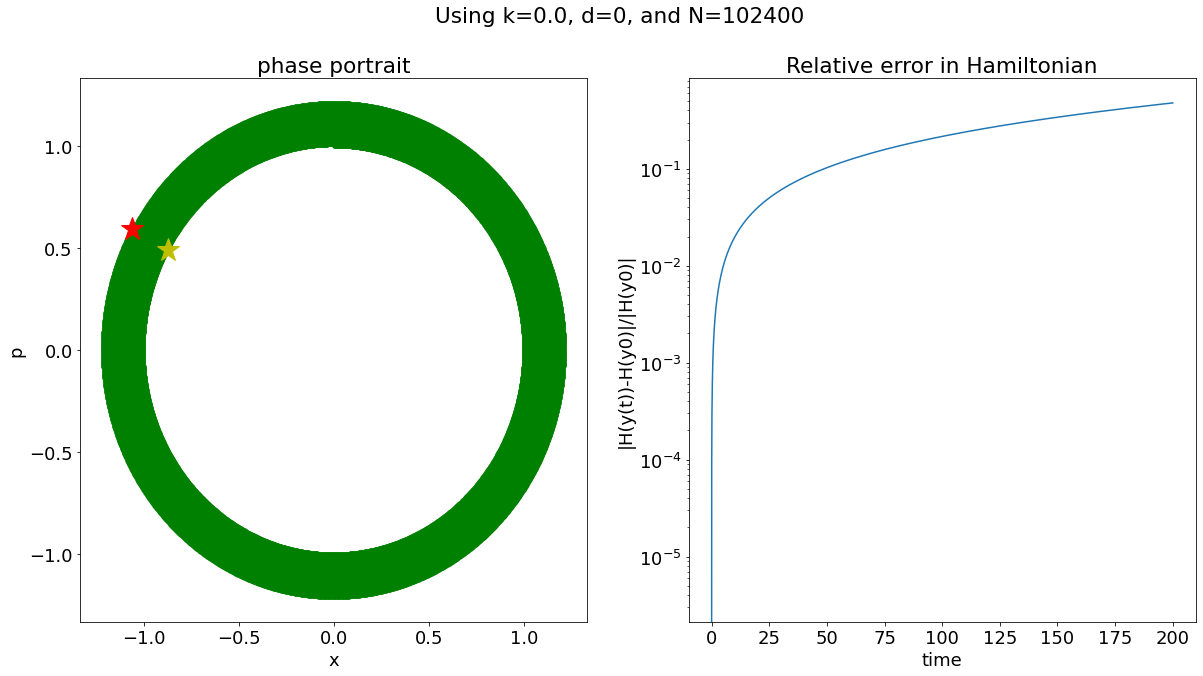

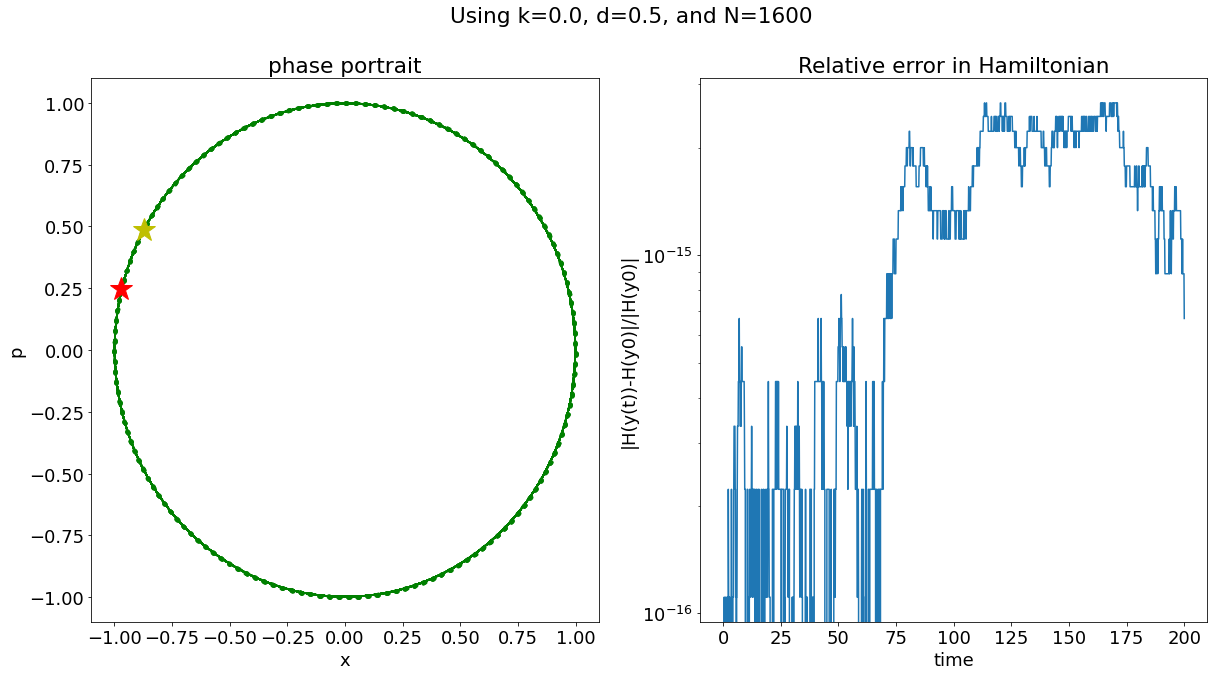

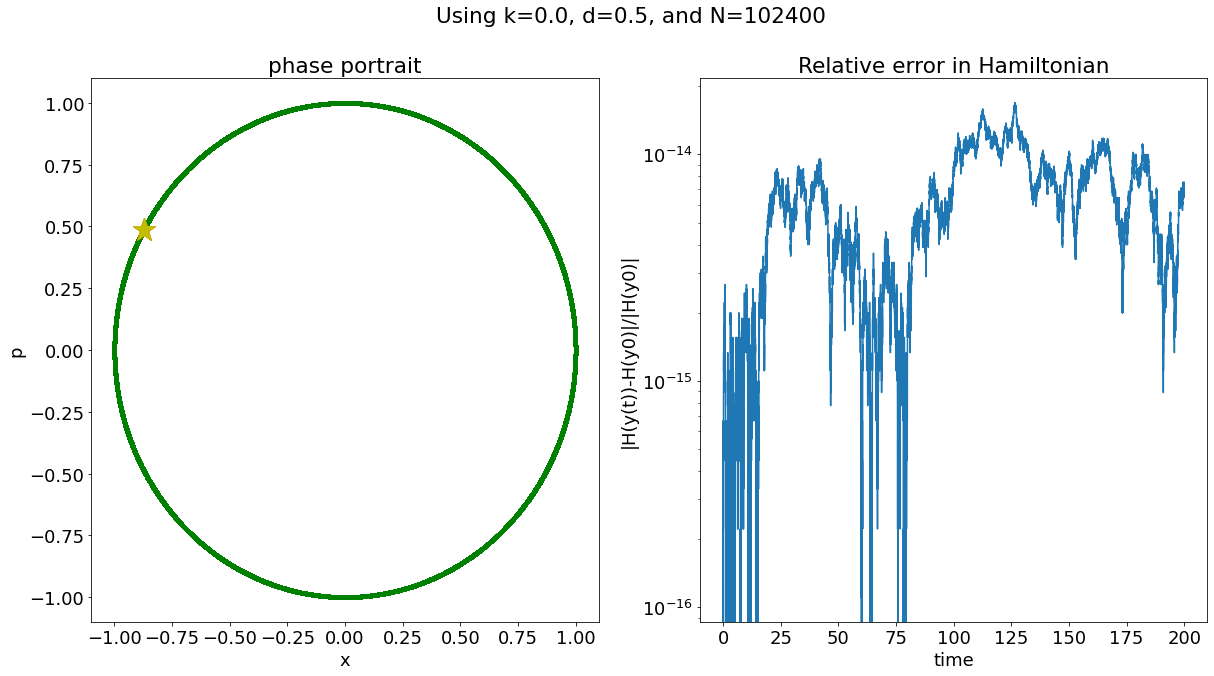

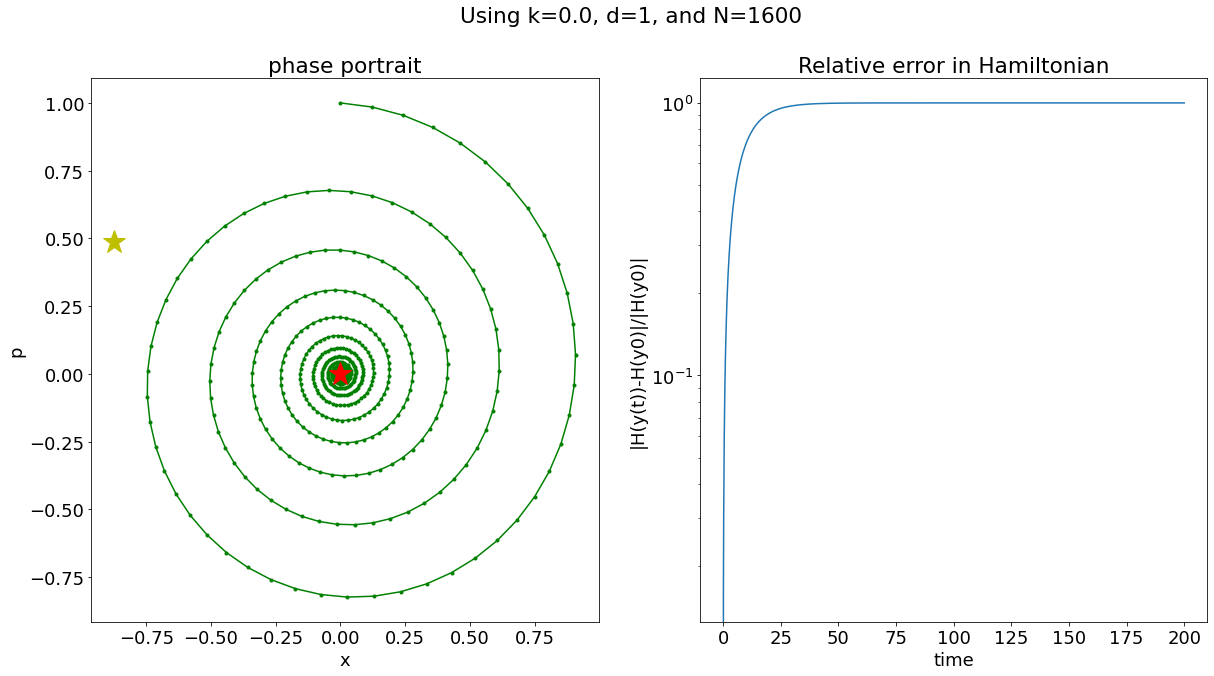

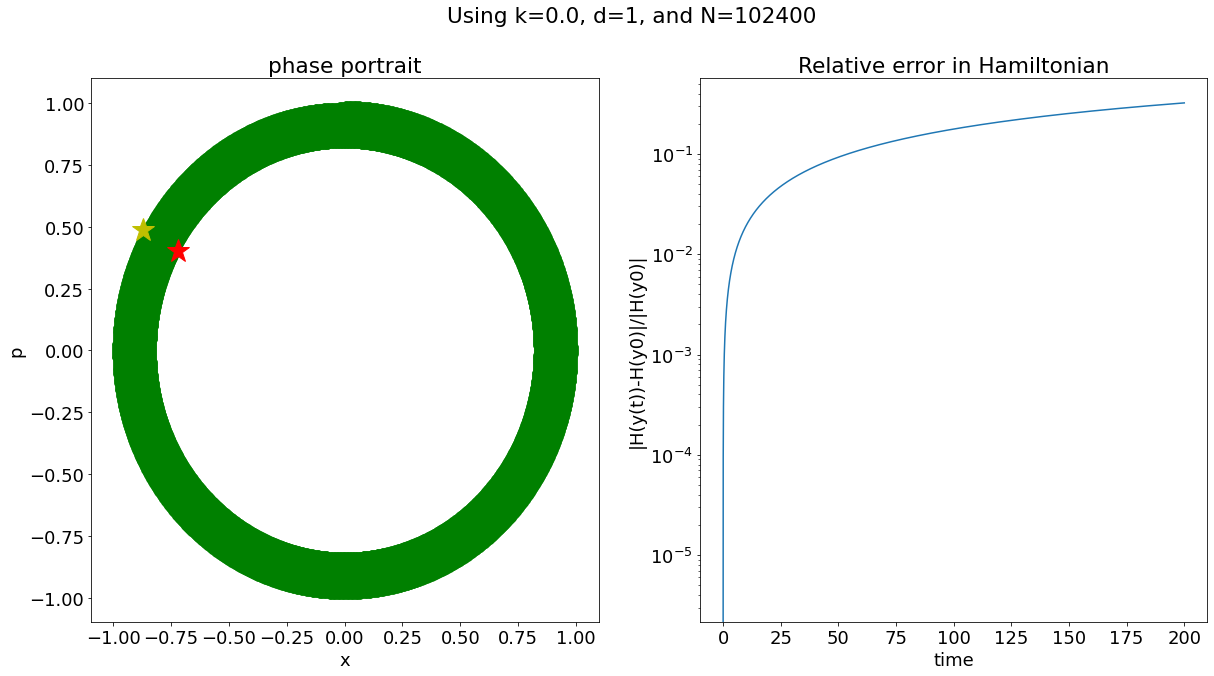

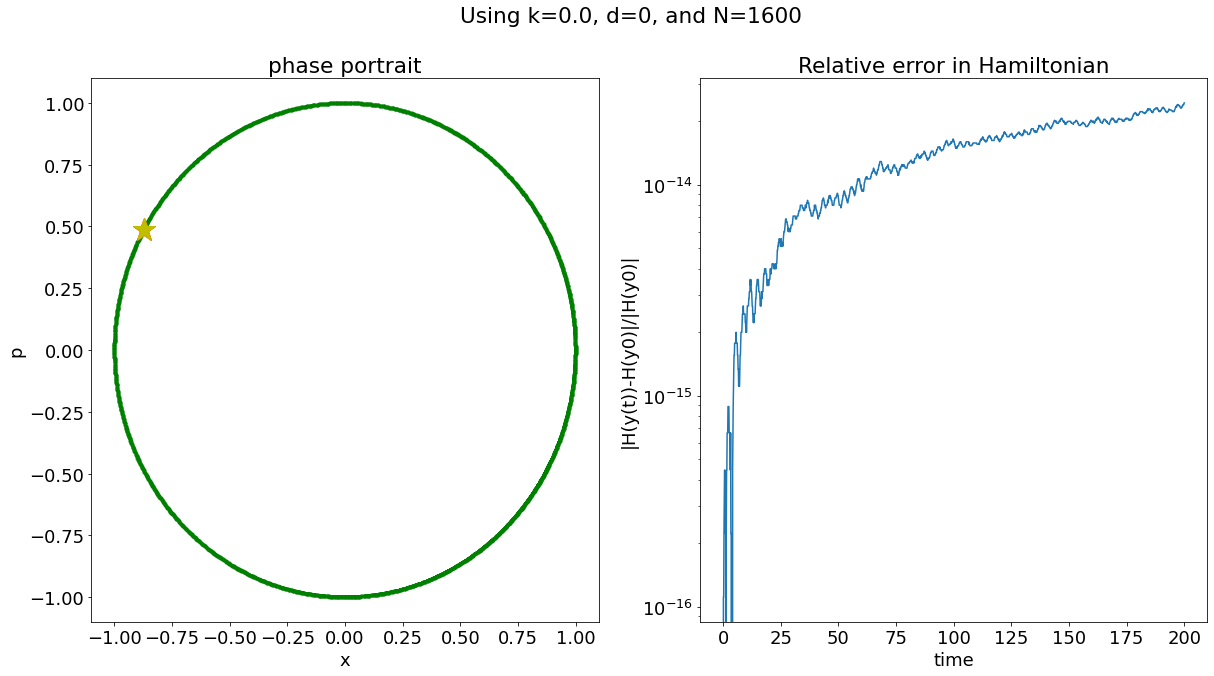

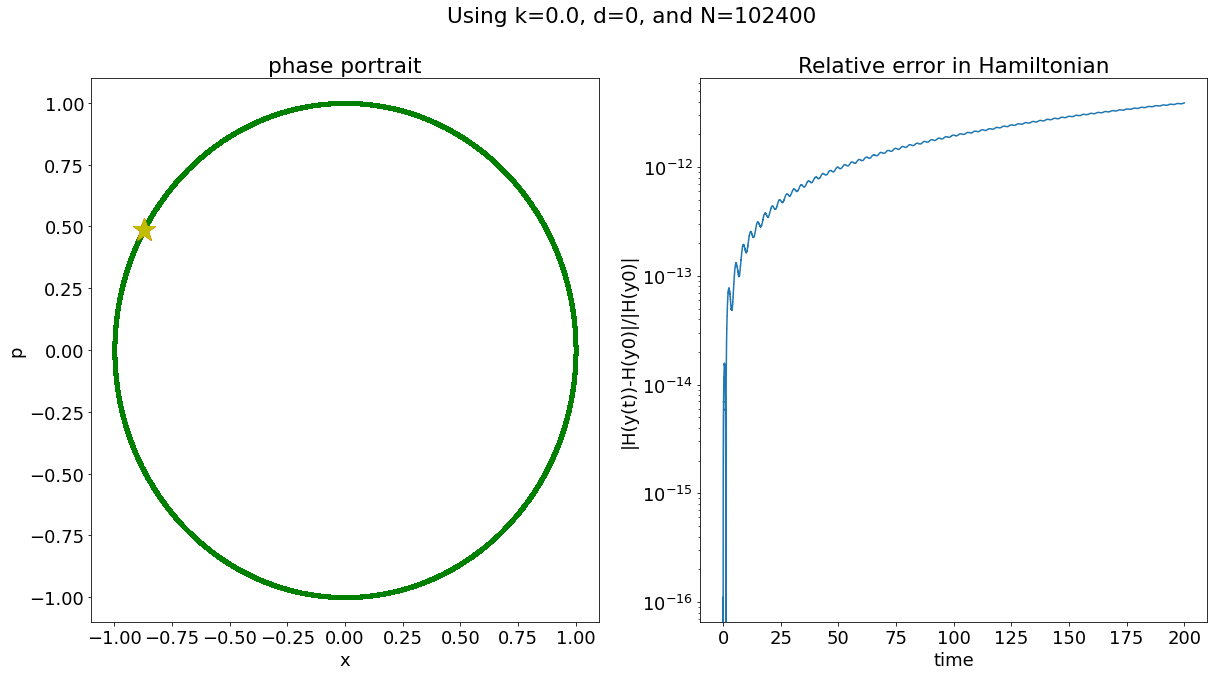

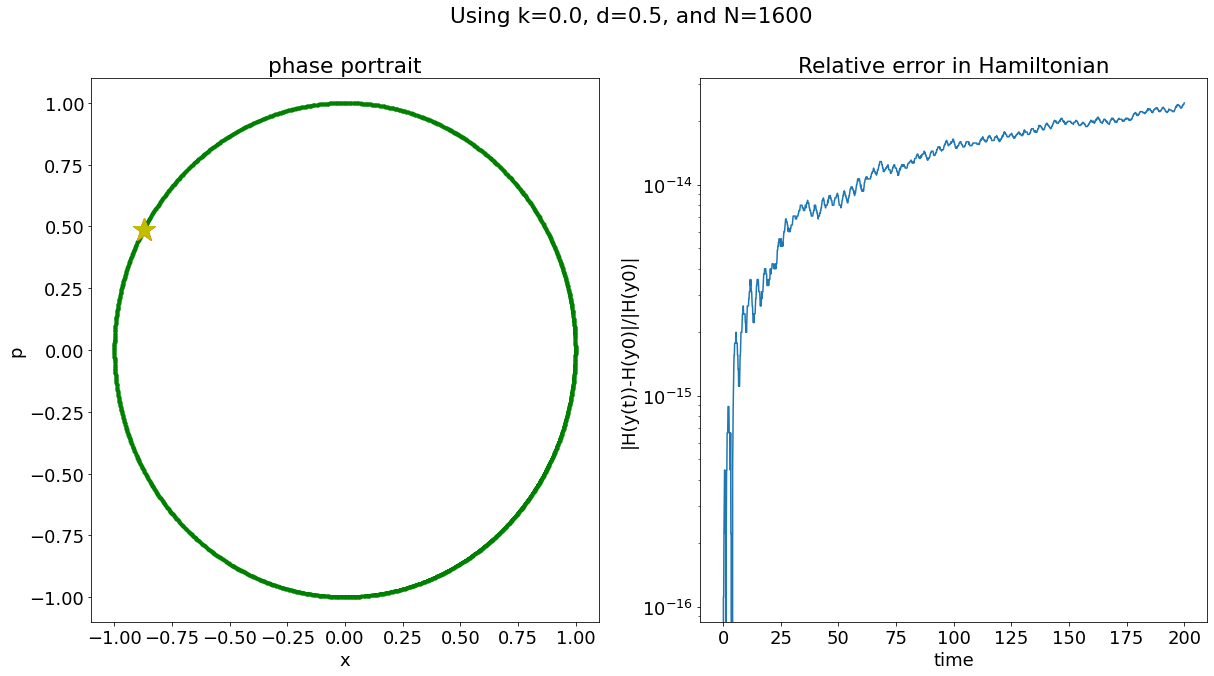

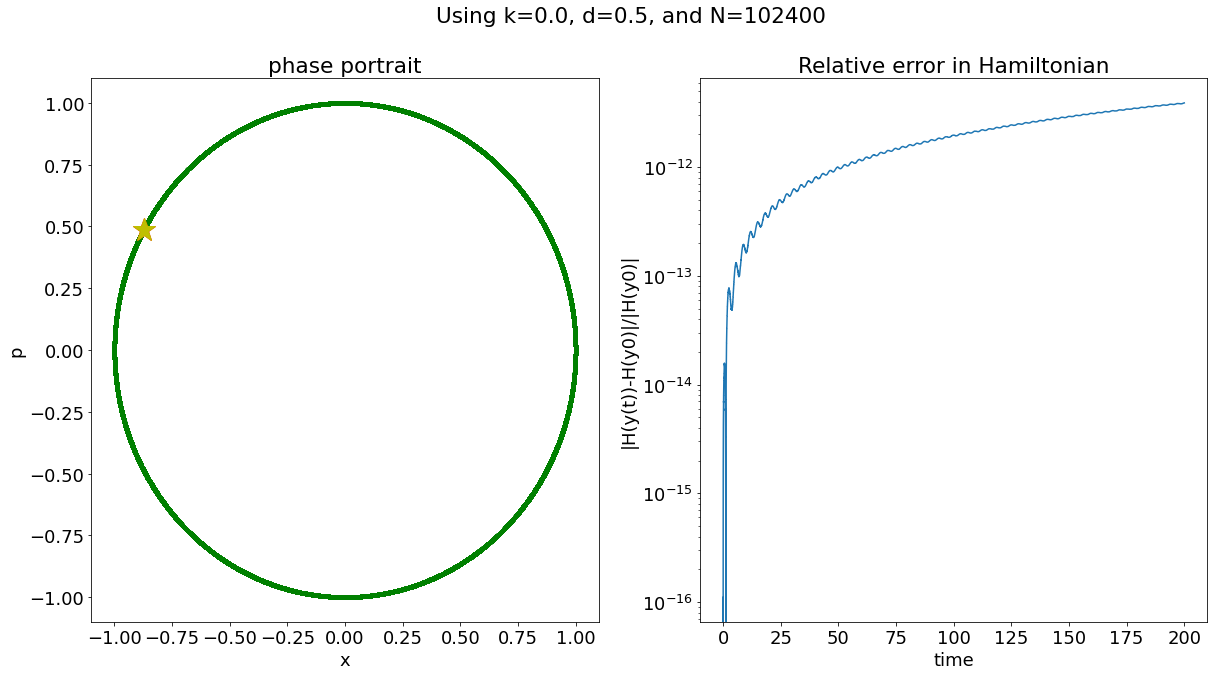

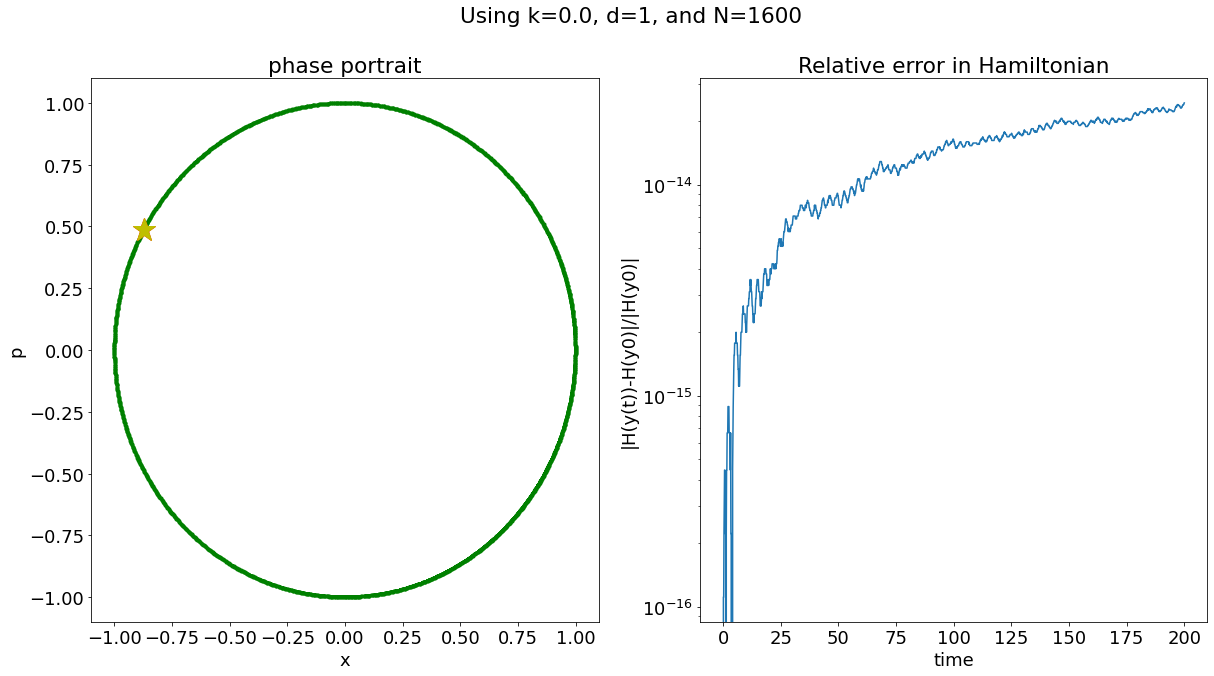

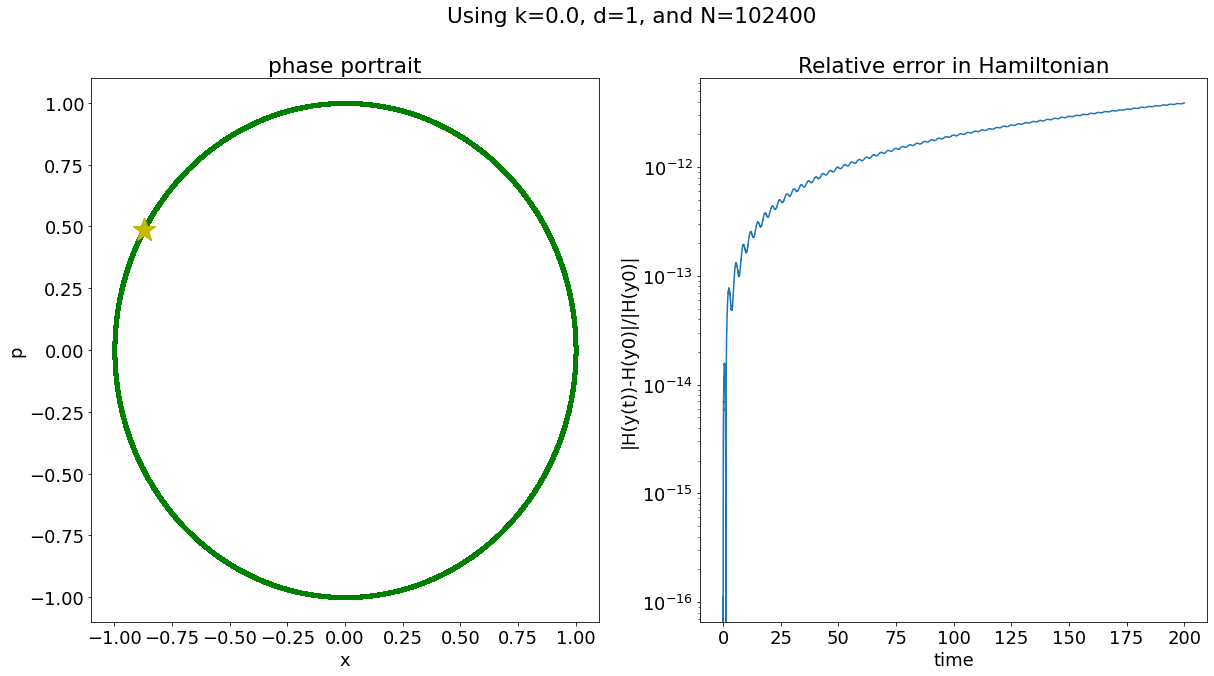

In [9]:
errors = compute(0.0)

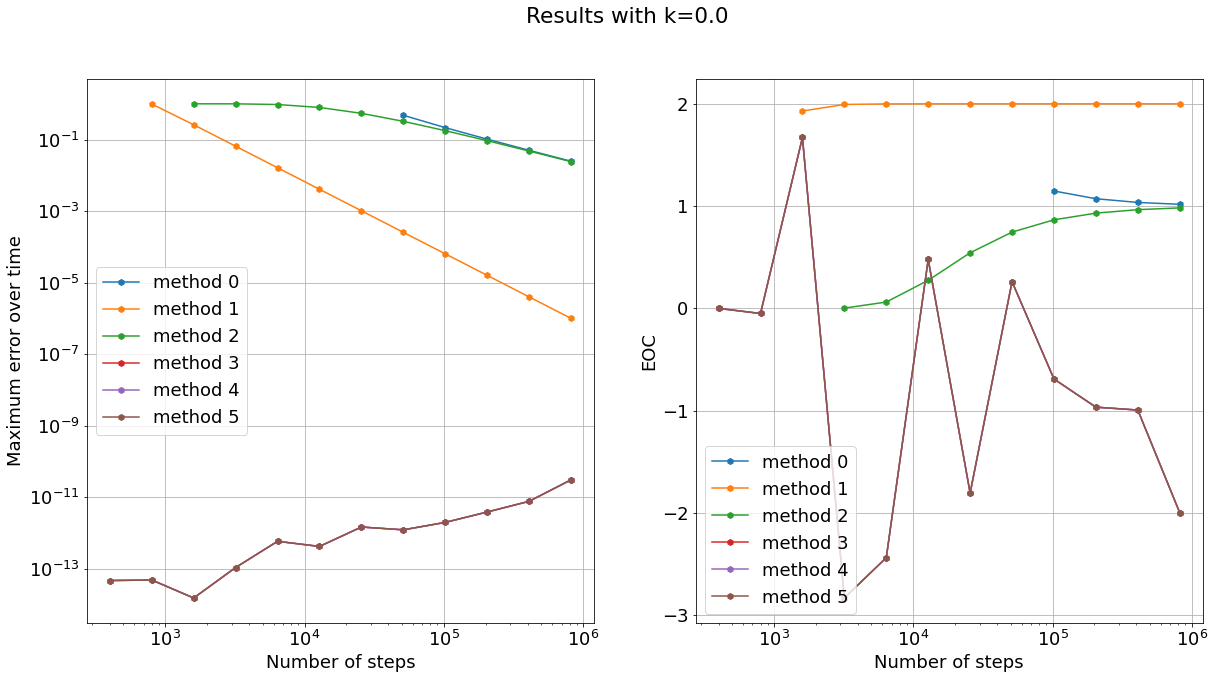

In [10]:
plotErrorEoc(0.0,errors)

Observations...

Investigate results for $k=0$:

/tmp/ipykernel_3208168/3584311436.py:6: RuntimeWarning: overflow encountered in double_scalars
  F  = lambda y: array( [0, 2*k*k*y[0]**3] )
/home/dedner/dunepy-core/lib/python3.8/site-packages/numpy/linalg/linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


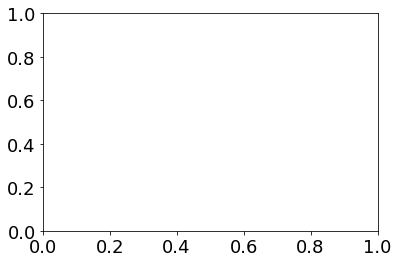

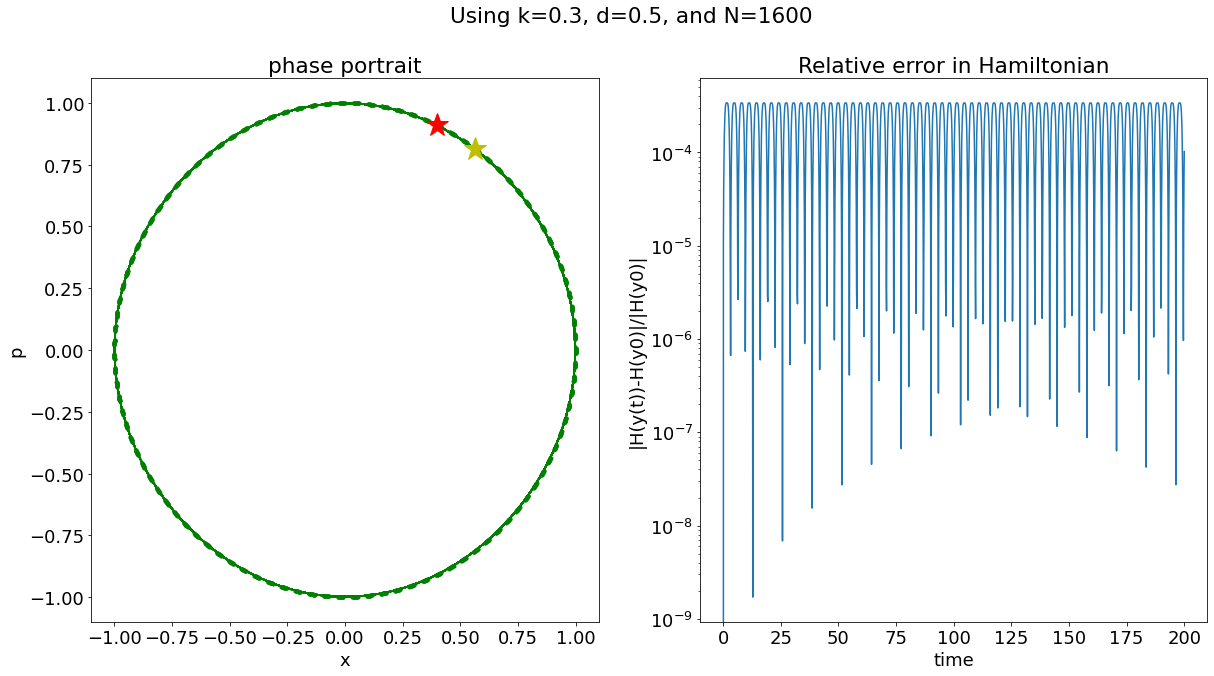

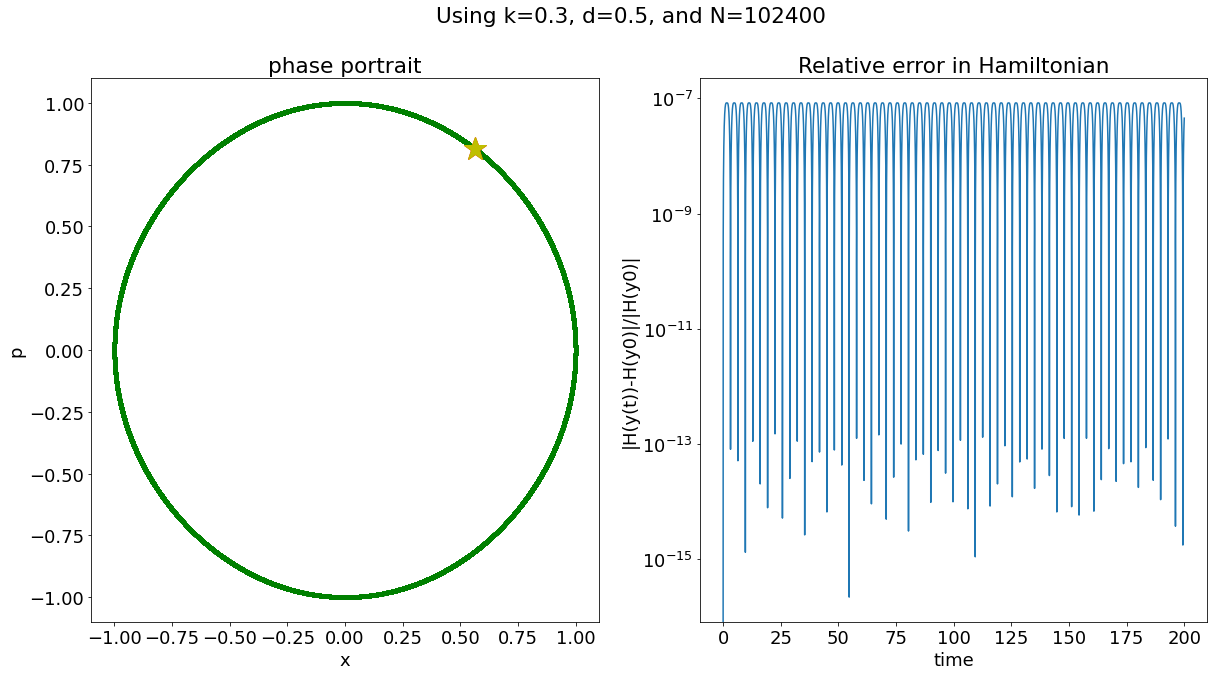

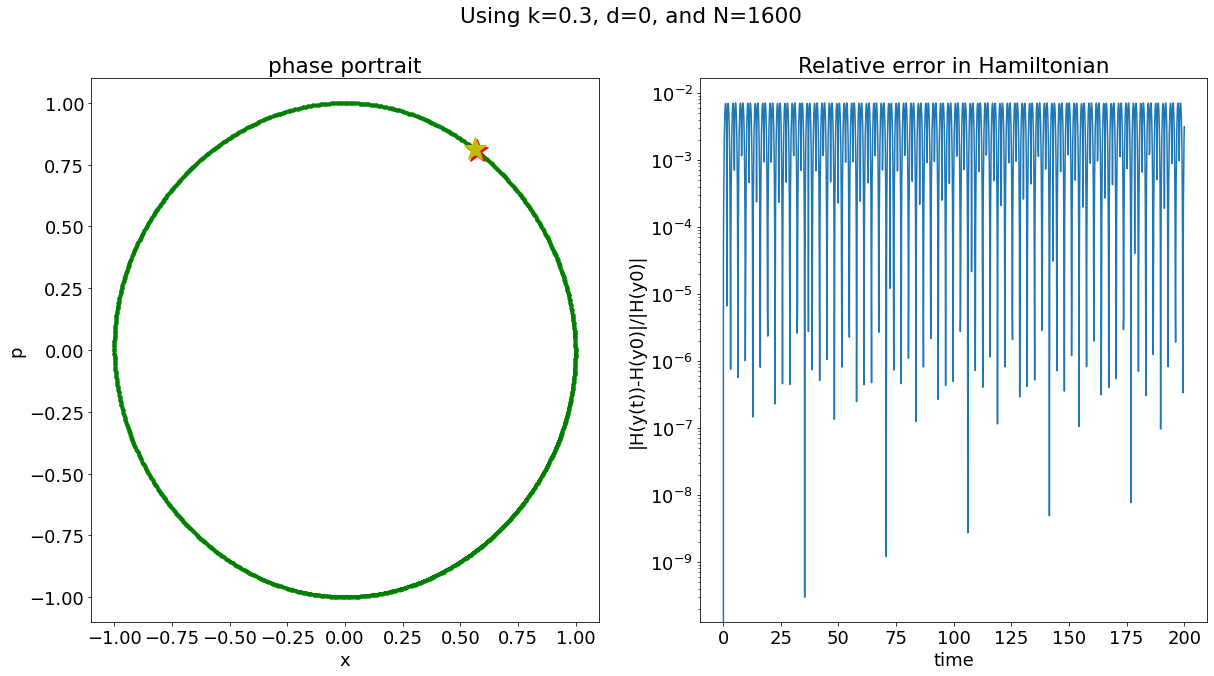

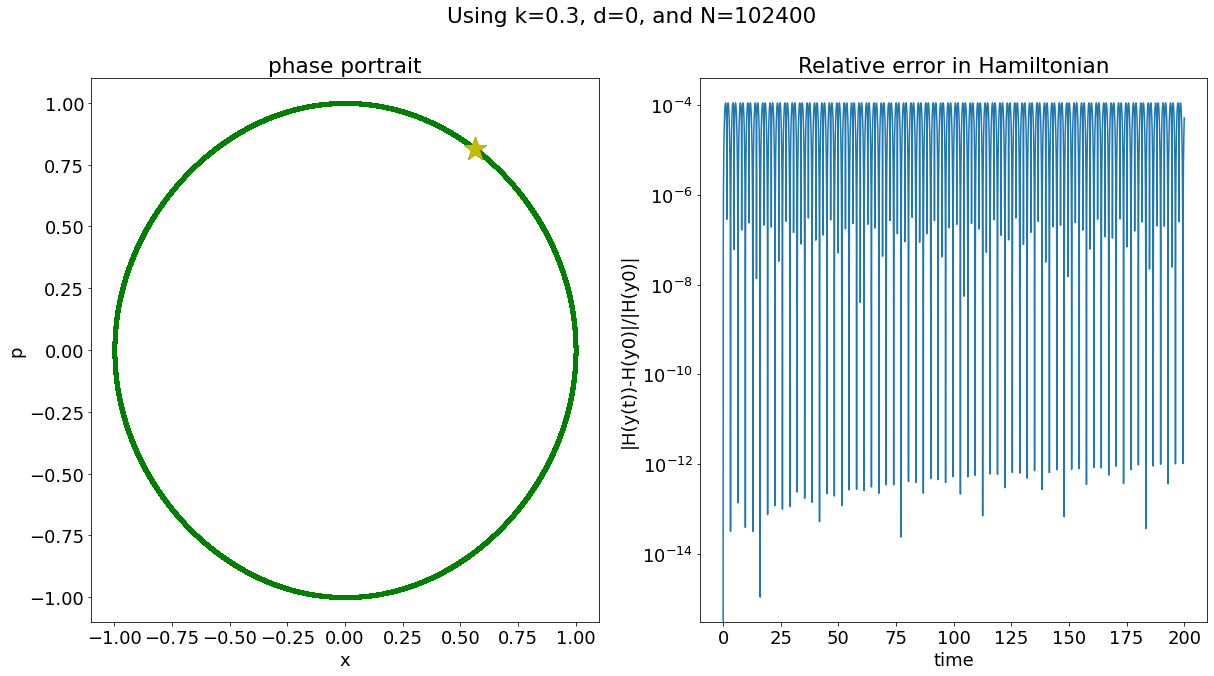

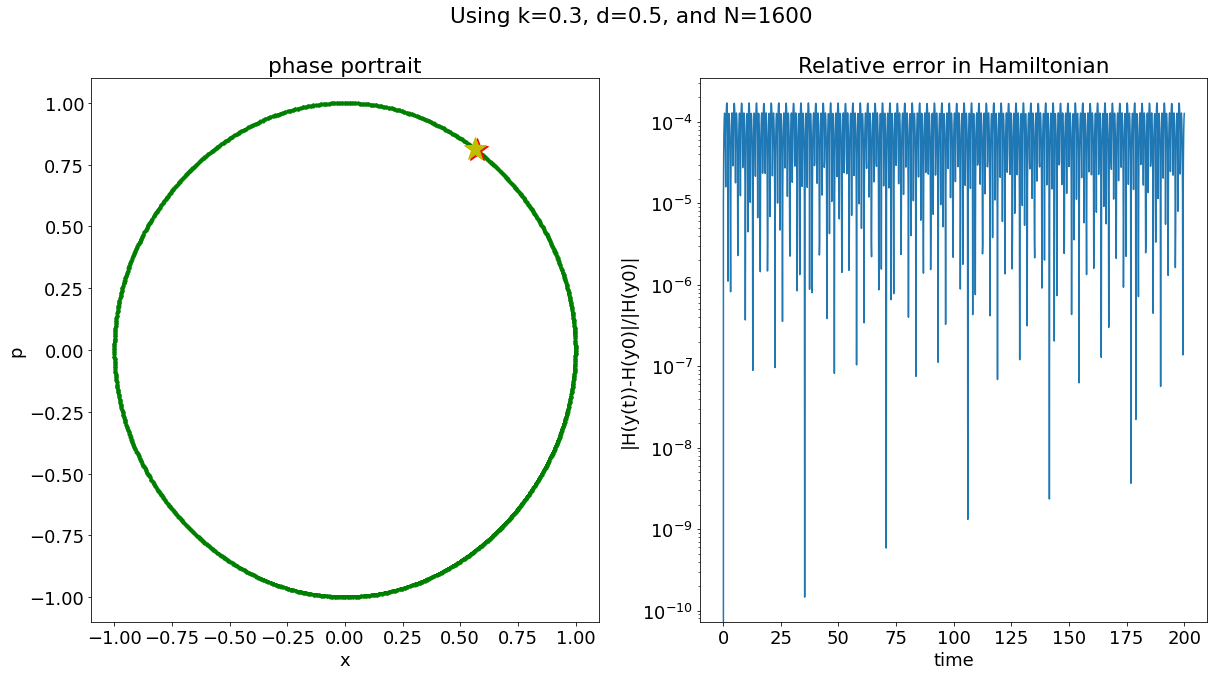

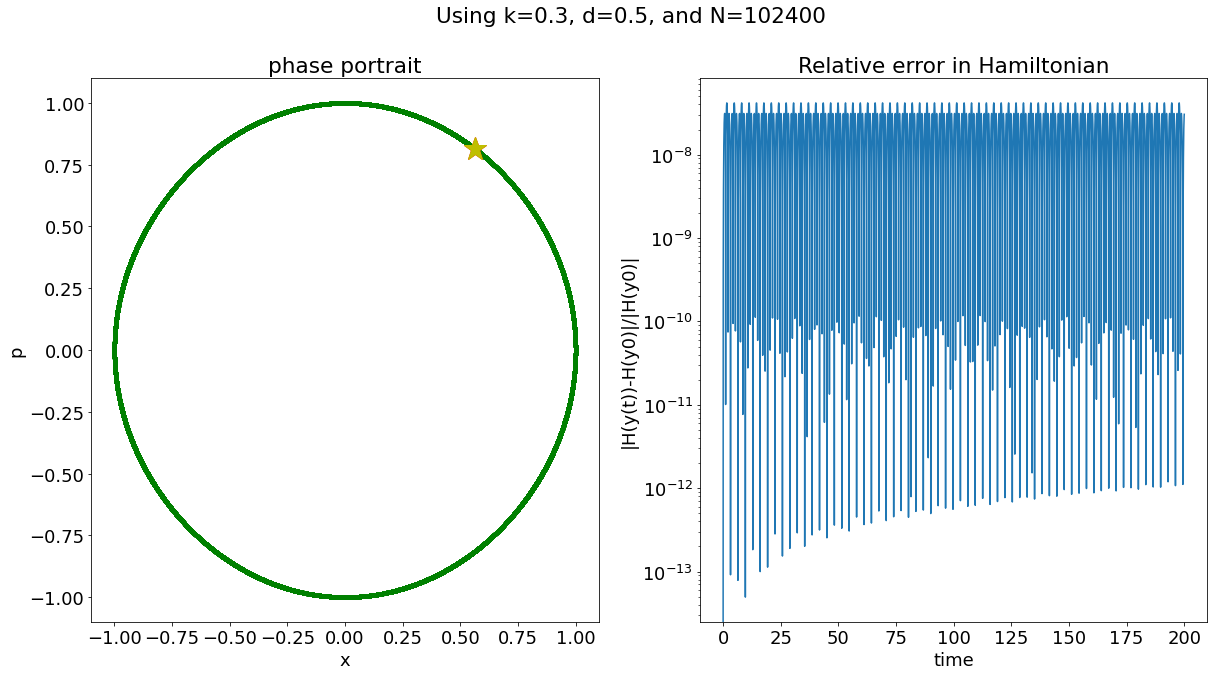

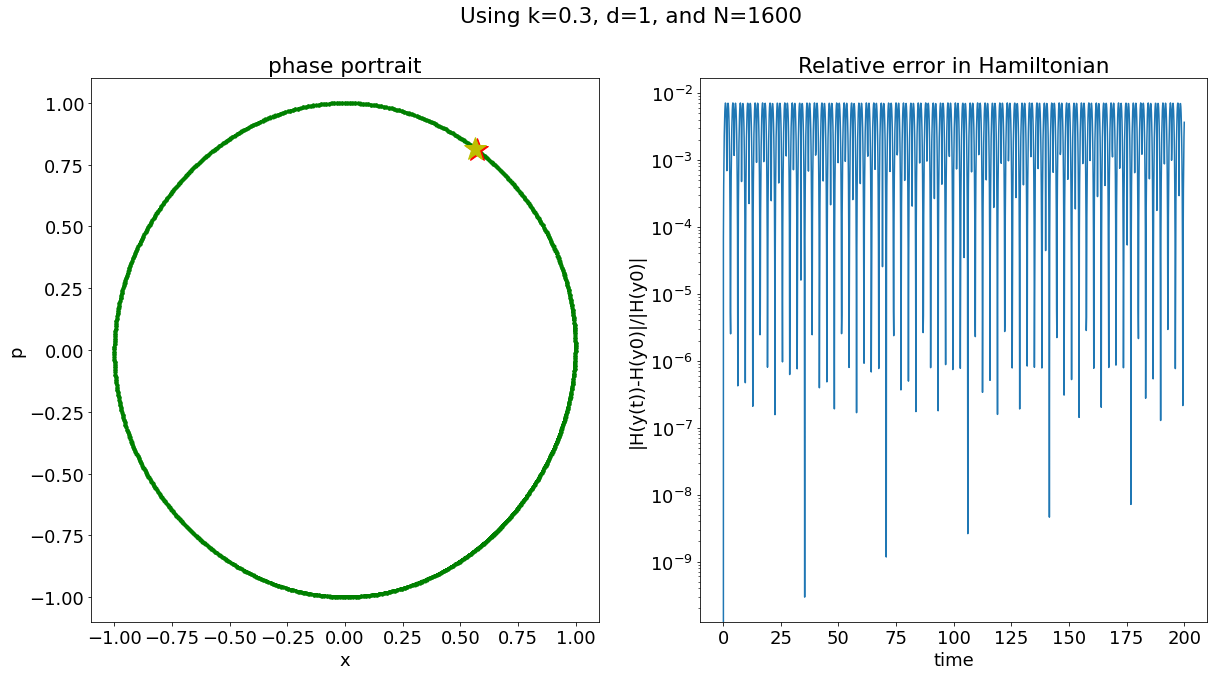

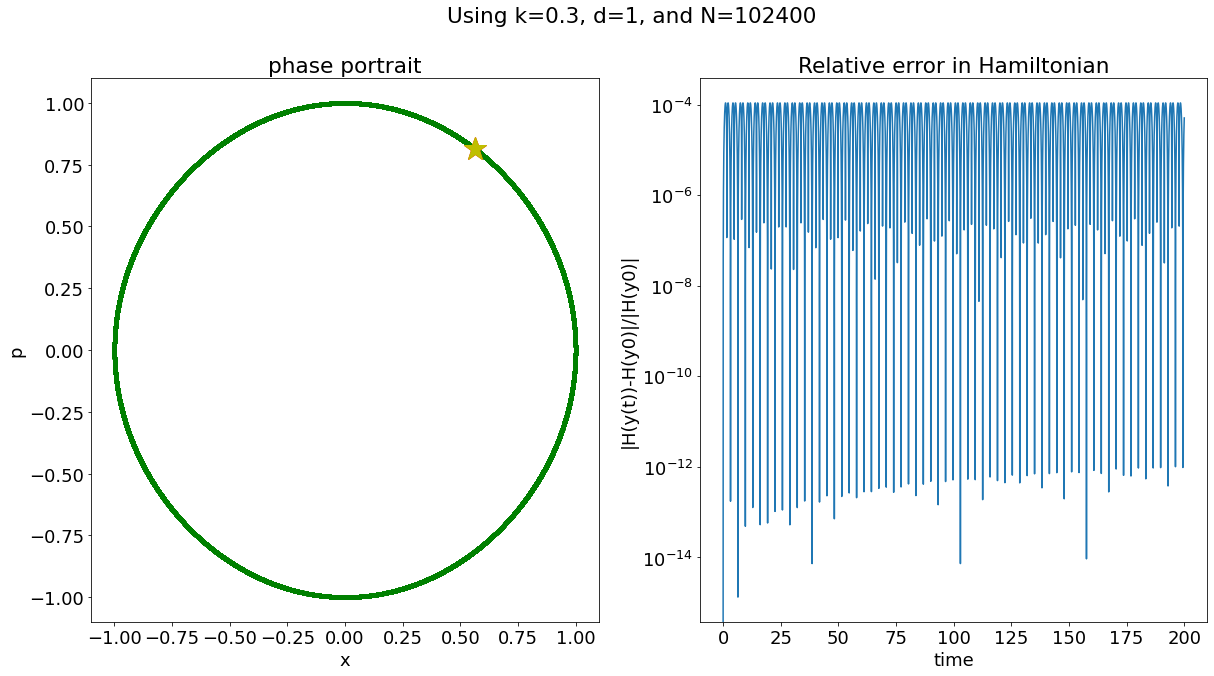

In [11]:
plt.cla() # avoid to many open figures
errors = compute(0.3)

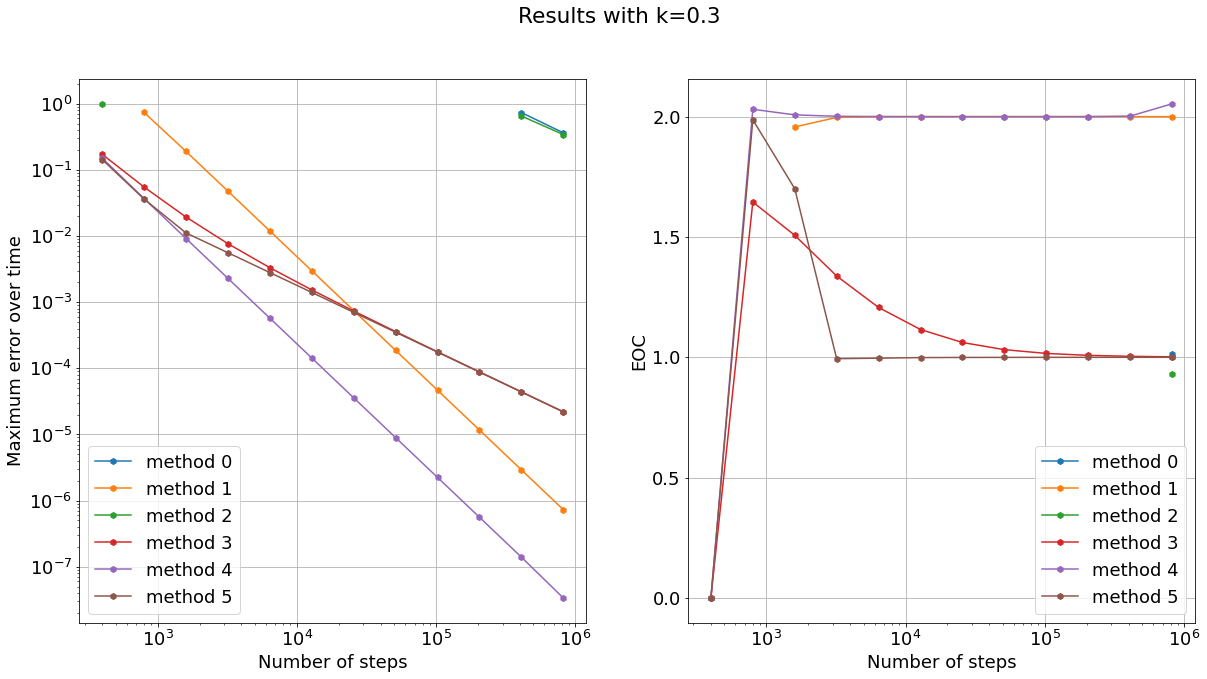

In [12]:
plotErrorEoc(0.3,errors)

Observations...

Investigate results for $k=0$:

/tmp/ipykernel_3208168/3584311436.py:6: RuntimeWarning: overflow encountered in double_scalars
  F  = lambda y: array( [0, 2*k*k*y[0]**3] )
/home/dedner/dunepy-core/lib/python3.8/site-packages/numpy/linalg/linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


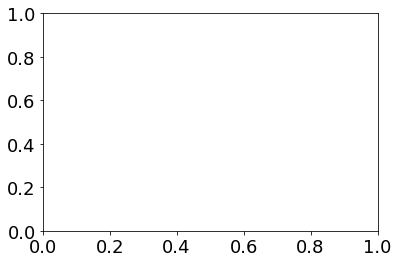

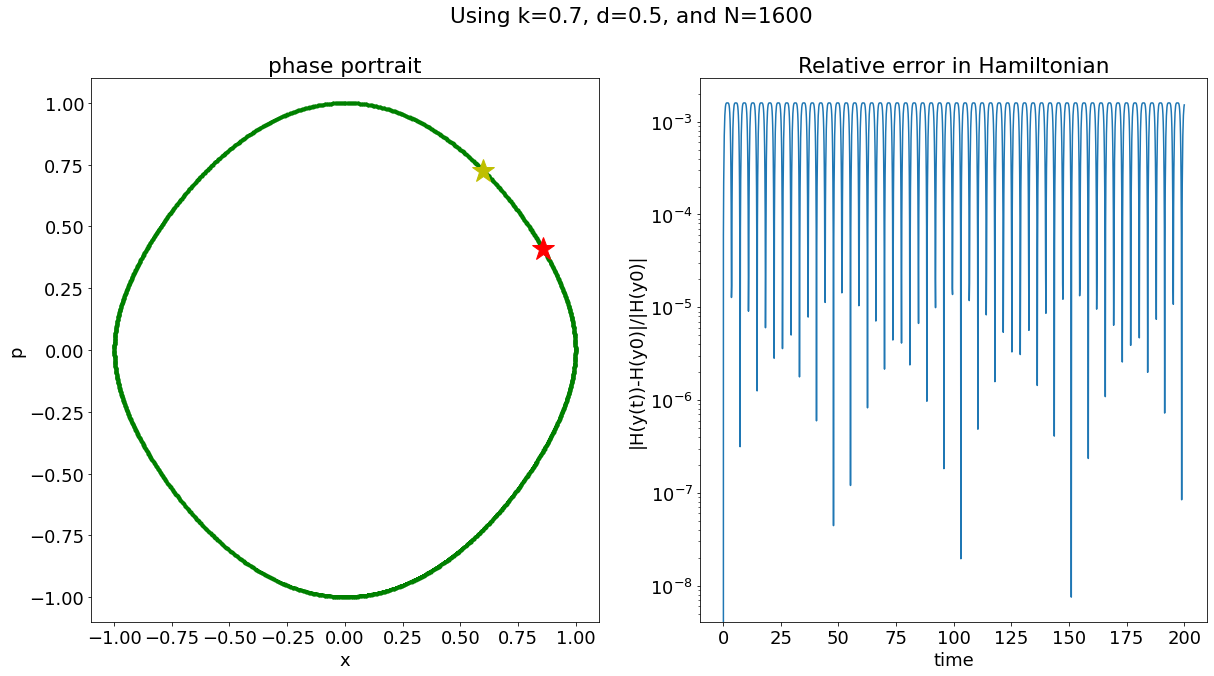

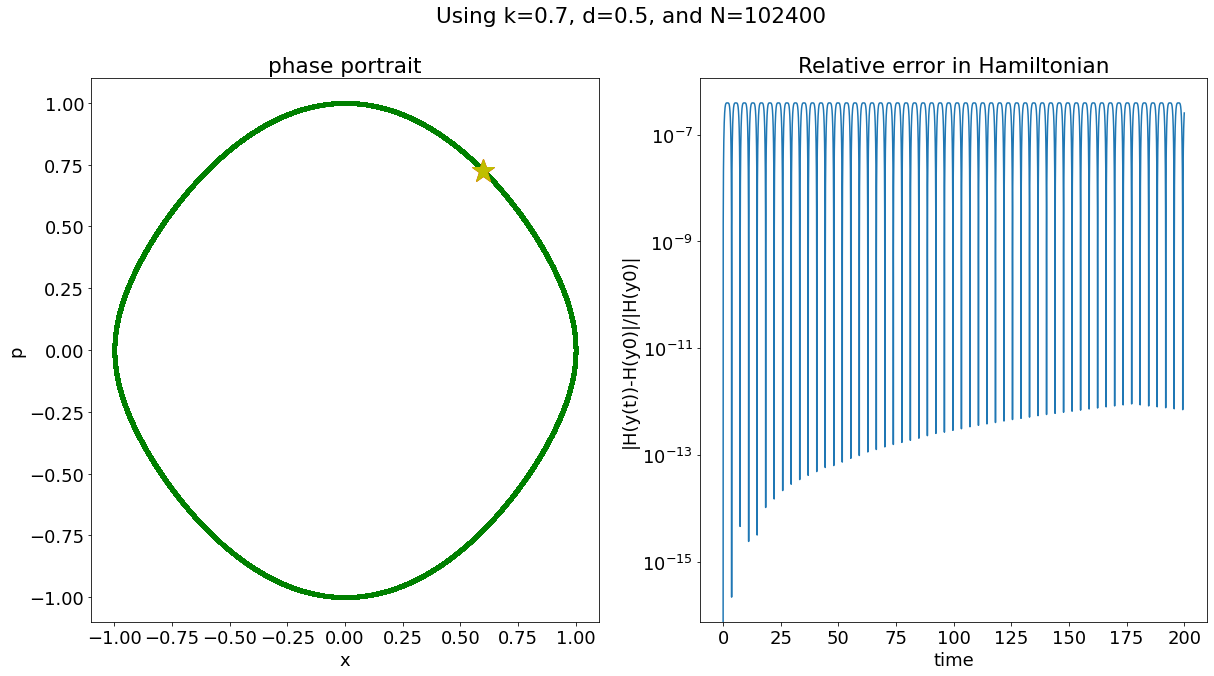

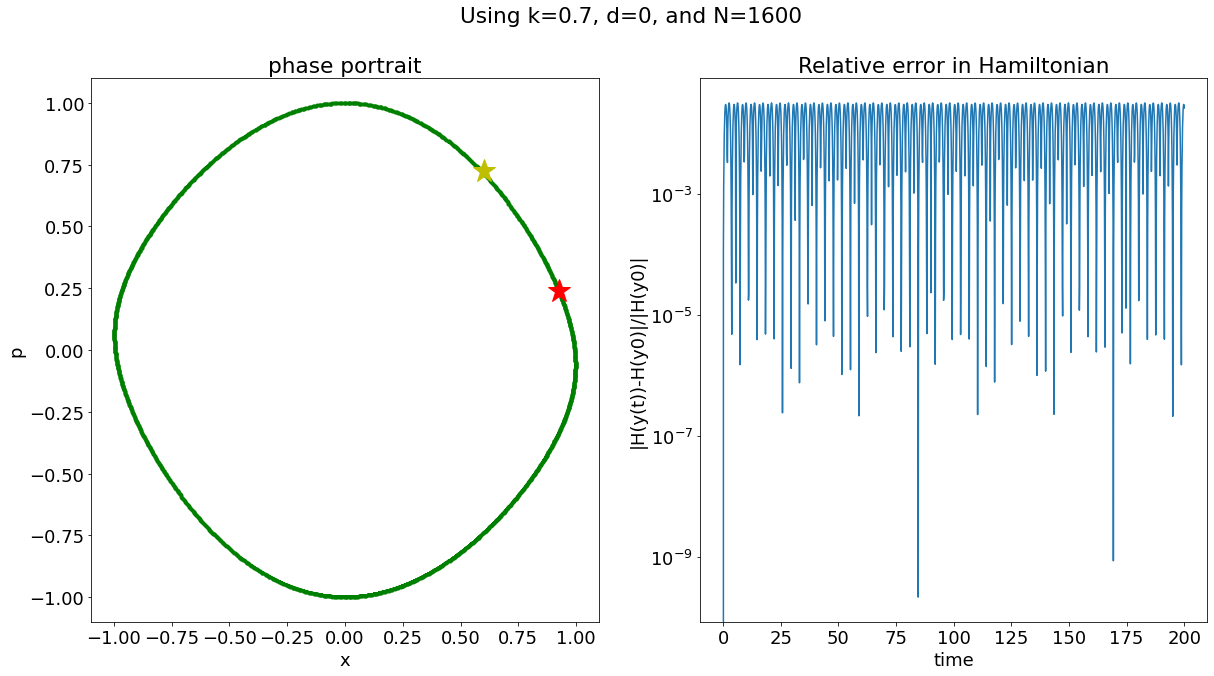

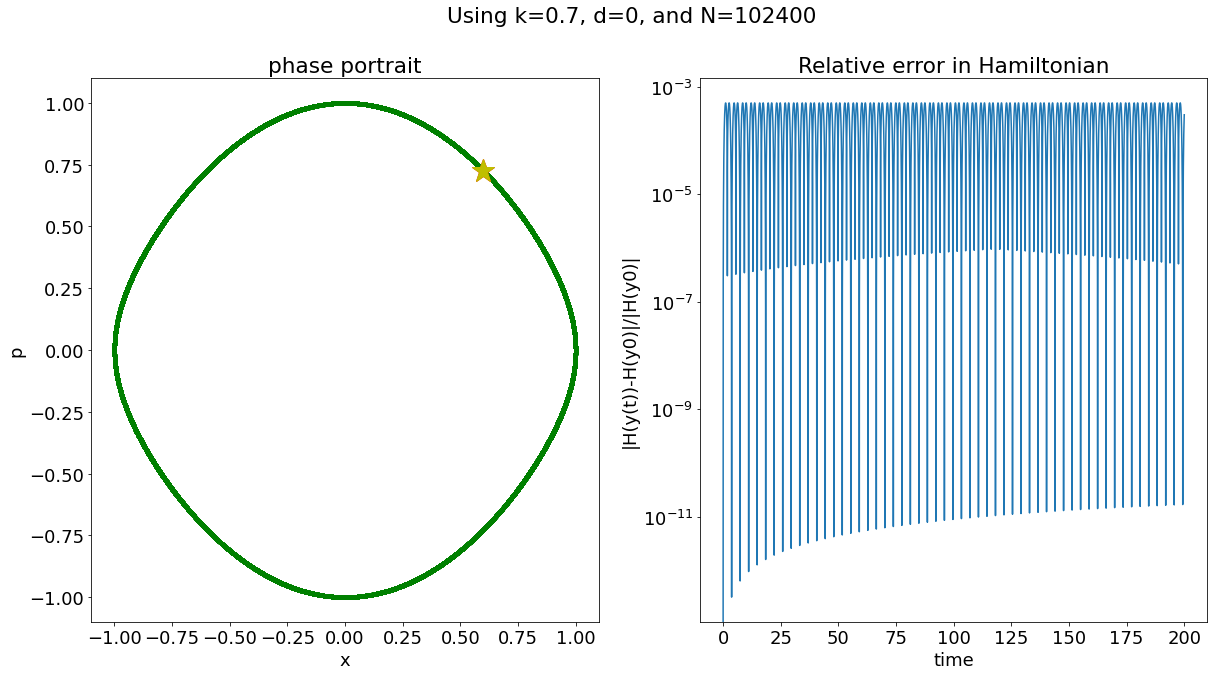

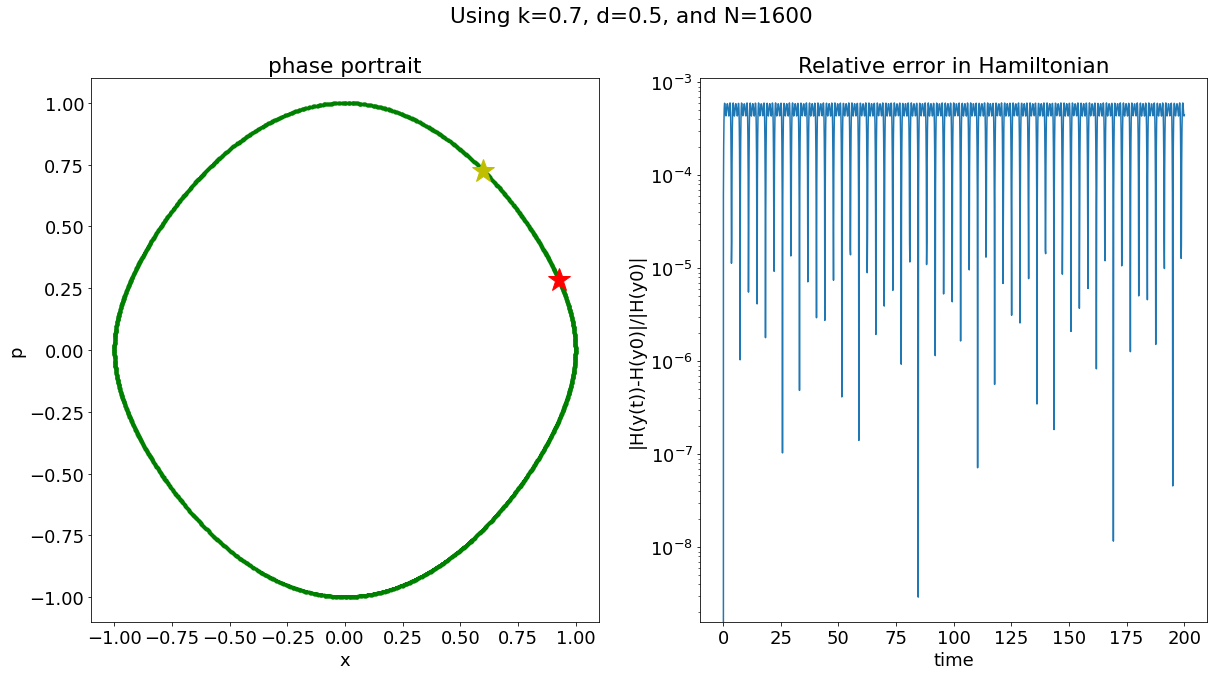

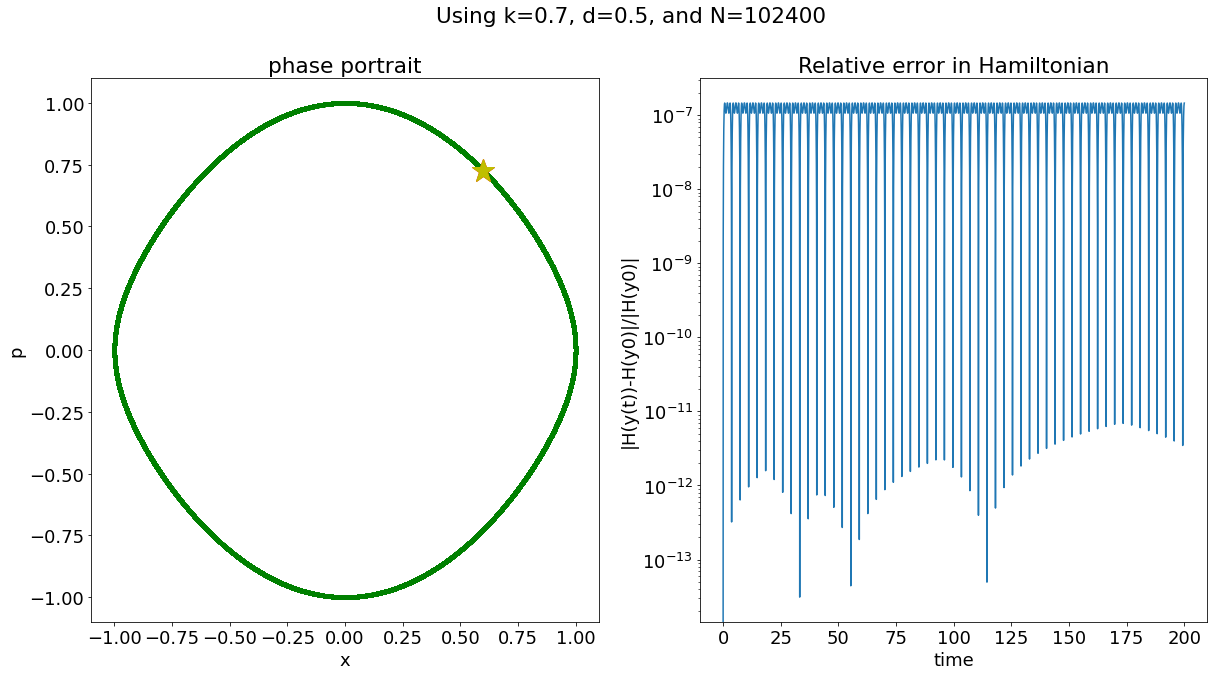

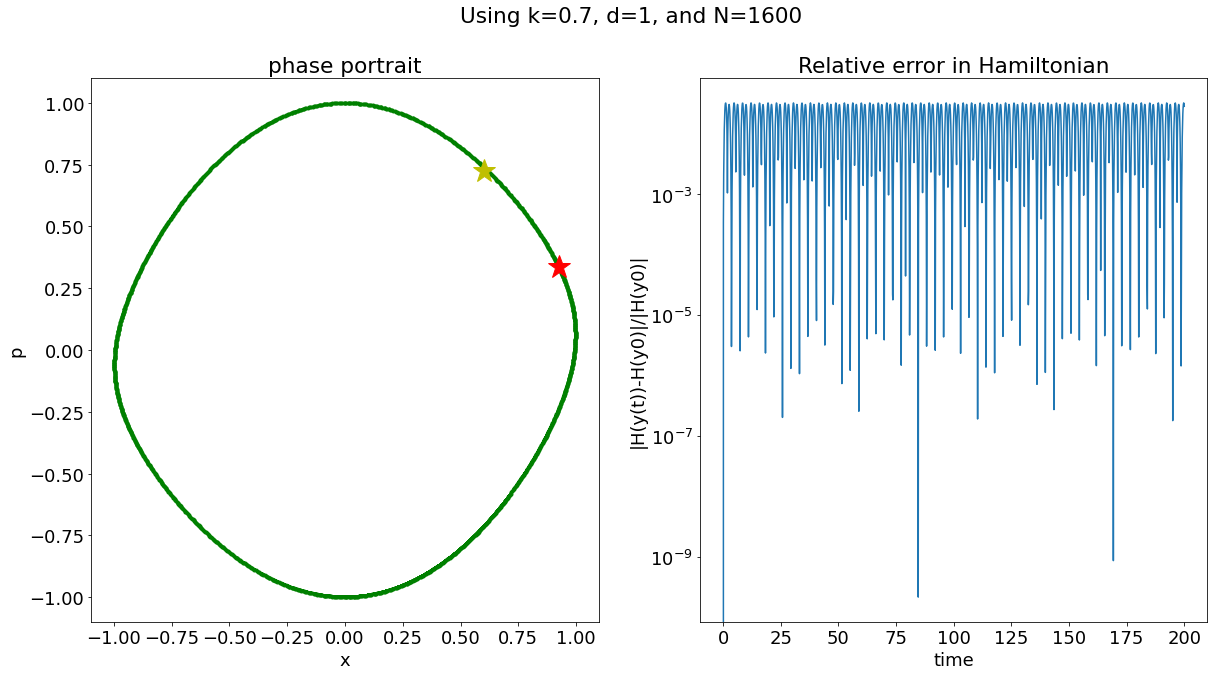

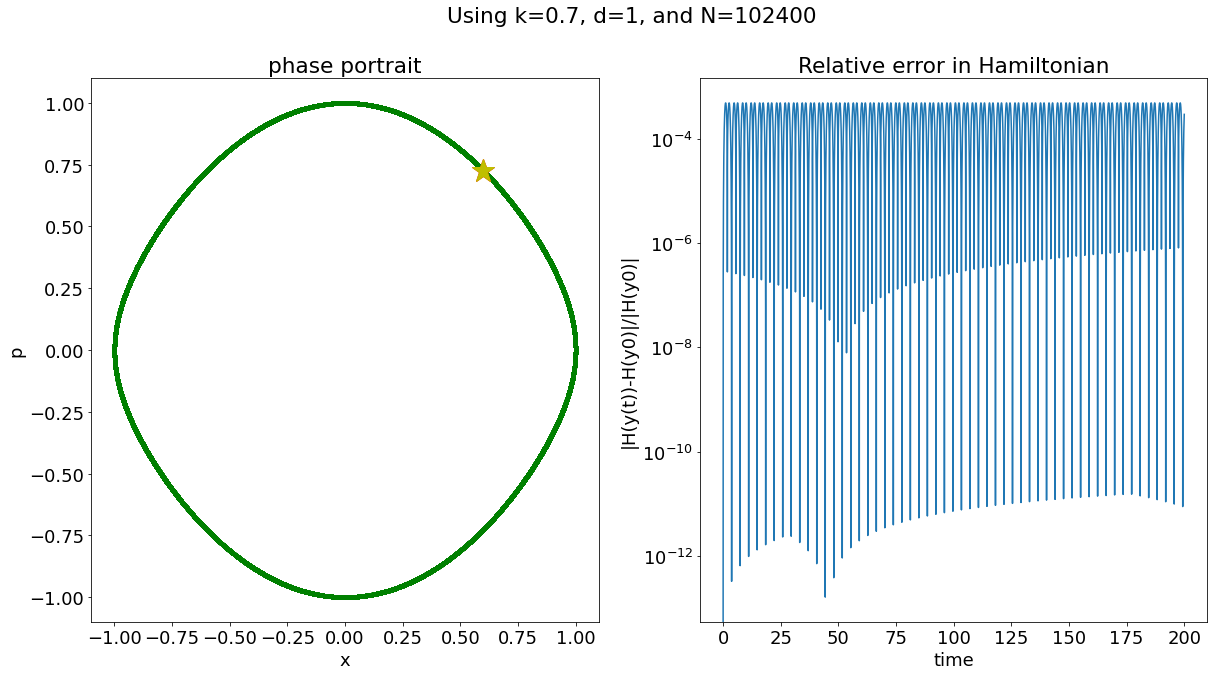

In [13]:
plt.cla() # avoid to many open figures
errors = compute(0.7)

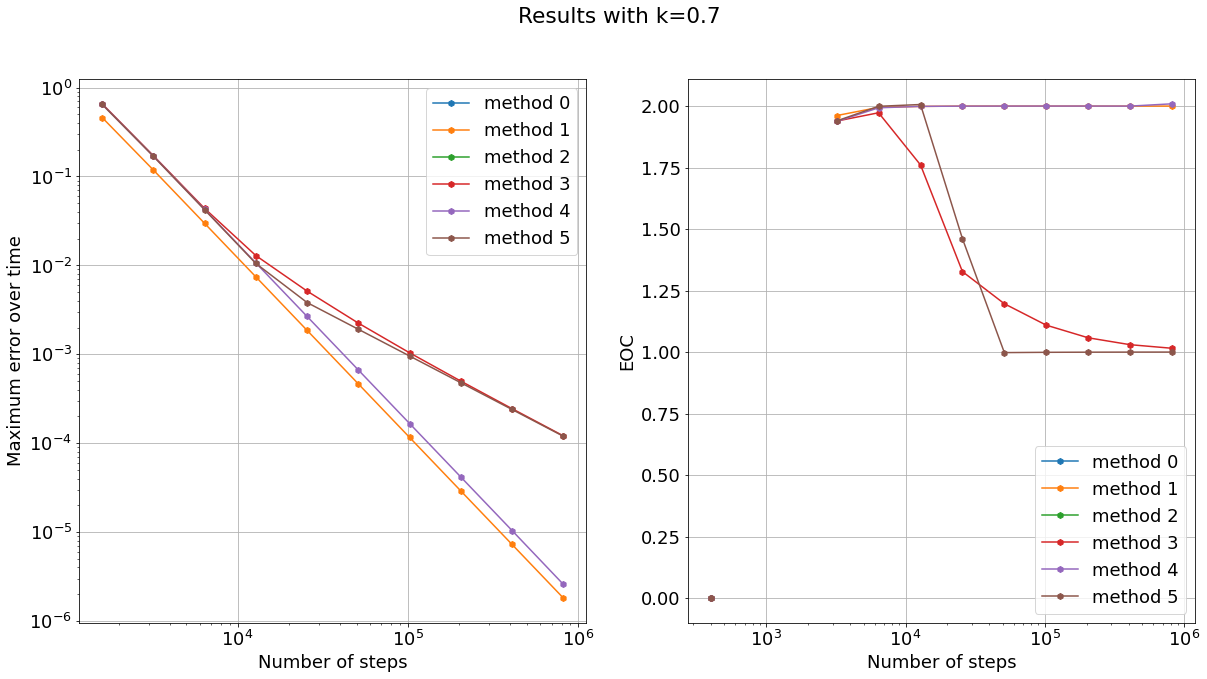

In [14]:
plotErrorEoc(0.7,errors)

Observations...